In [1]:
import math

import cv2
import torch
import torchvision.ops.boxes as bops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

In [2]:
def stable(wind):
    """
    Determines if wind direction is stable.
    First way is checking if wind direction changes by more than 10 degrees every hours.
    Second way is checking if the total wind direction change is more than 30 degrees.
    """
    times = []
    speeds = []
    phis = []
    for w in wind.split('@'):
        li = w.split('$')
        u, v = li[0], li[1]
        u = np.array(u.split('#')).astype(float)
        v = np.array(v.split('#')).astype(float)
        t = li[2]
        times.append(t)
        speeds.append((u ** 2 + v ** 2) ** 0.5)
        phis.append(np.mod(180 + 180 / np.pi * np.arctan2(u, v), 360))
        phi = np.mod(180 + 180 / np.pi * np.arctan2(u, v), 360)
        # First method
        if (np.abs(np.diff(phi)) > 10).any():
            return False
        # Second method
        # if phi.max() - phi.min() > 30:
        #     return False
    return True

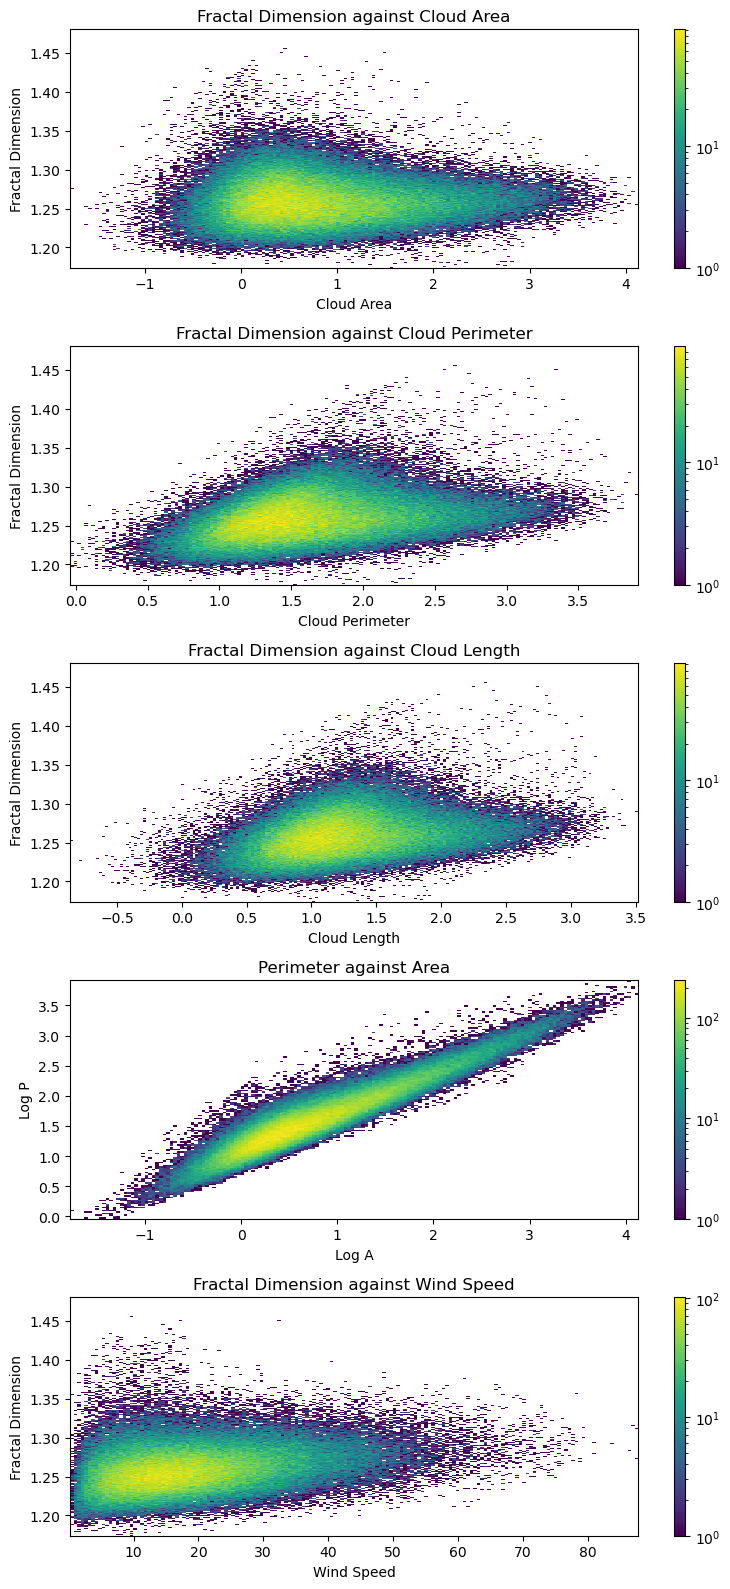

Fractal Dimension: 1.259853750804581
Number of clouds: 163378


In [3]:
ARRAY_JOB_ID = 0
NUM_JOBS = 1407

df = pd.DataFrame()
fractal_dimensions = []
for i in range(NUM_JOBS):
    try:
        df = pd.concat([df, pd.read_csv(f'./{ARRAY_JOB_ID}/{i}', index_col=0)])
    except:
        continue

# Removing clouds with unstable wind directions tend to only remove bigger clouds
# and reduce the fractal dimension
# winds = df['winds']
# mask_wind = [stable(wind) for wind in winds]
# df = df[mask_wind]

# Threshold of 24 pixels is used as previous literature found objects smaller than 24 pixels
# had too little resolution to be used for estimating fractal dimension accurately
df = df[df['area_px'] >= 24]

# Convert km to mm to reduce spread of fractal dimension values
df['area_mm'] = df['area_km'] * 1000000000000
df['perimeter_mm'] = df['perimeter_km'] * 1000000
x = np.log10(df['area_mm'])
y = np.log10(df['perimeter_mm'])
m, b = np.polyfit(x, y, 1)
c = 10 ** b
for i, row in df.iterrows():
    fractal_dimension = math.log(row['perimeter_mm'] / c, row['area_mm']) * 2
    fractal_dimensions.append(fractal_dimension)

df['area_km'] = np.log10(df['area_km'])
df['perimeter_km'] = np.log10(df['perimeter_km'])
df['length_km'] = np.log10(df['length_km'])
df['fractal_dimension'] = fractal_dimensions

bin_area = np.histogram_bin_edges(df['area_km'], bins='auto')
bin_perimeter = np.histogram_bin_edges(df['perimeter_km'], bins='auto')
bin_length = np.histogram_bin_edges(df['length_km'], bins='auto')
bin_fractal = np.histogram_bin_edges(df['fractal_dimension'], bins='auto')
bin_wind = np.histogram_bin_edges(df['wind_speed'], bins='auto')

fig, ax = plt.subplots(5, figsize=(8, 16))

counts, xedges, yedges, im = ax[0].hist2d(df['area_km'], df['fractal_dimension'], bins=[bin_area, bin_fractal], norm=mcolors.LogNorm())
ax[0].set_title('Fractal Dimension against Cloud Area')
ax[0].set_xlabel('Cloud Area')
ax[0].set_ylabel('Fractal Dimension')
fig.colorbar(im, ax=ax[0])

counts, xedges, yedges, im = ax[1].hist2d(df['perimeter_km'], df['fractal_dimension'], bins=[bin_perimeter, bin_fractal], norm=mcolors.LogNorm())
ax[1].set_title('Fractal Dimension against Cloud Perimeter')
ax[1].set_xlabel('Cloud Perimeter')
ax[1].set_ylabel('Fractal Dimension')
fig.colorbar(im, ax=ax[1])

counts, xedges, yedges, im = ax[2].hist2d(df['length_km'], df['fractal_dimension'], bins=[bin_length, bin_fractal], norm=mcolors.LogNorm())
ax[2].set_title('Fractal Dimension against Cloud Length')
ax[2].set_xlabel('Cloud Length')
ax[2].set_ylabel('Fractal Dimension')
fig.colorbar(im, ax=ax[2])

counts, xedges, yedges, im = ax[3].hist2d(df['area_km'], df['perimeter_km'], bins=[bin_area, bin_perimeter], norm=mcolors.LogNorm())
ax[3].set_title('Perimeter against Area')
ax[3].set_xlabel('Log A')
ax[3].set_ylabel('Log P')
fig.colorbar(im, ax=ax[3])

counts, xedges, yedges, im = ax[4].hist2d(df['wind_speed'], df['fractal_dimension'], bins=[bin_wind, bin_fractal], norm=mcolors.LogNorm())
ax[4].set_title('Fractal Dimension against Wind Speed')
ax[4].set_xlabel('Wind Speed')
ax[4].set_ylabel('Fractal Dimension')
fig.colorbar(im, ax=ax[4])
plt.tight_layout()
plt.show()

print(f'Fractal Dimension: {m * 2}')
print(f'Number of clouds: {df.shape[0]}')

In [4]:
def intersect(box1, box2):
    """
    Determines whether an OpenCV bounding box intersects another bounding box.
    Used for determining when an ice cloud region is in contact with a rainy region
    and thus precipitating.

    Args:
        box1: first bounding box
        box2: second bounding box

    Returns:
        intersects: boolean on whether the boxes intersect
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    torch_box1 = torch.tensor(np.array([[x1, y1, x1 + w1, y1 + h1]]), dtype=torch.float)
    torch_box2 = torch.tensor(np.array([[x2, y2, x2 + w2, y2 + h2]]), dtype=torch.float)
    iou = bops.box_iou(torch_box1, torch_box2)
    return not not iou.any()

def longest_edge(contour):
    """
    Calculates the longest straight edge of a contour.
    Value can be used to determine whether a significant section of the cloud has been cut off
    by attenuation or border of the plot which affects how crinkly the perimeter is.

    Args:
        contour: contour around the cloud
    
    Returns:
        longest_edge: longest straight edge of the cloud
    """
    prev_diff = None
    length = 0
    max_length = 0
    for i in range(len(contour) - 1):
        diff = contour[i] - contour[i + 1]
        if (diff == prev_diff).all():
            length += 1
        else:
            length = 1
        prev_diff = diff
        max_length = max(length, max_length)
    return max_length

def get_contours(img_hsv, img_gray, hsv_values):
    """
    Find contours by thresholding images with HSV values.

    Args:
        img_hsv: image in HSV format
        img_gray: grayscale image
        hsv_values: values to determine what colour to find contours around

    Returns:
        contours: contours found
    """
    mask = cv2.inRange(img_hsv, hsv_values, hsv_values)
    img = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    img[img != 0] = 255
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    return contours

def find_clouds(file_name):
    """
    Finds clouds that fulfill certain criteria which will be used to calculate fractal dimension.

    Args:
        file_name: name of image file to find clouds in

    Returns:
        img: the image read from the file
        contours_ice: contours of all valid ice clouds
    """
    img = cv2.imread(file_name)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask_drop = cv2.inRange(img_hsv, (119, 159, 185), (119, 159, 185))
    img[:, :1317, :][mask_drop[:, :1317] > 0] = (187, 176, 160)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    contours_drizzle = get_contours(img_hsv, img_gray, (102, 221, 243))
    contours_melt = get_contours(img_hsv, img_gray, (19, 255, 255))
    contours_ice = get_contours(img_hsv, img_gray, (102, 37, 187))

    contours_ice = [contour for contour in contours_ice if cv2.contourArea(contour) > 0]
    contours_melt = [contour for contour in contours_melt if cv2.contourArea(contour) > 0]
    contours_drizzle = [contour for contour in contours_drizzle if cv2.contourArea(contour) > 0]
    
    box_melt = []
    box_ice = []
    box_drizzle = []
    box_corrupt = []
    to_remove = []
    
    for contour in contours_ice:
        x, y, w, h = cv2.boundingRect(contour)
        if y < 42 or x > 1317:
            box_corrupt.append([x, y, w, h])
        box_ice.append([x, y, w, h])
    
    for contour in contours_melt:
        x, y, w, h = cv2.boundingRect(contour)
        y -= 2
        box_melt.append([x, y, w, h])

    for contour in contours_drizzle:
        x, y, w, h = cv2.boundingRect(contour)
        y -= 2
        box_drizzle.append([x, y, w, h])
    
    for i, v in enumerate(box_ice):
        if longest_edge(contours_ice[i]) / cv2.arcLength(contours_ice[i], True) > 0.3:
            to_remove.append(i)
        else:
            for j in box_melt + box_drizzle + box_corrupt:
                if intersect(v, j):
                    to_remove.append(i)
                    break
    
    for i in sorted(to_remove, reverse=True):
        contours_ice.pop(i)
    
    return img, contours_ice

Average wind speeds of clouds in the box: 19.5348787118898
Number of clouds in the box: 163378


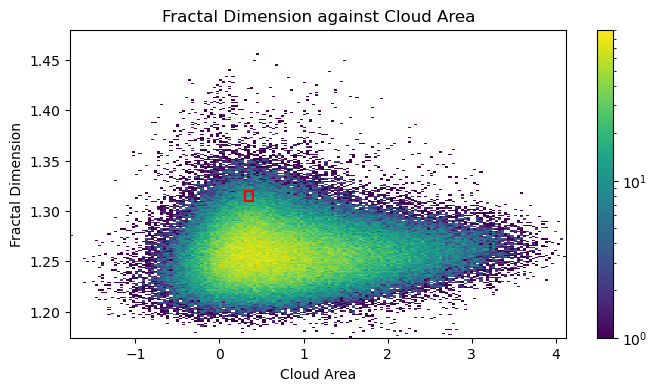

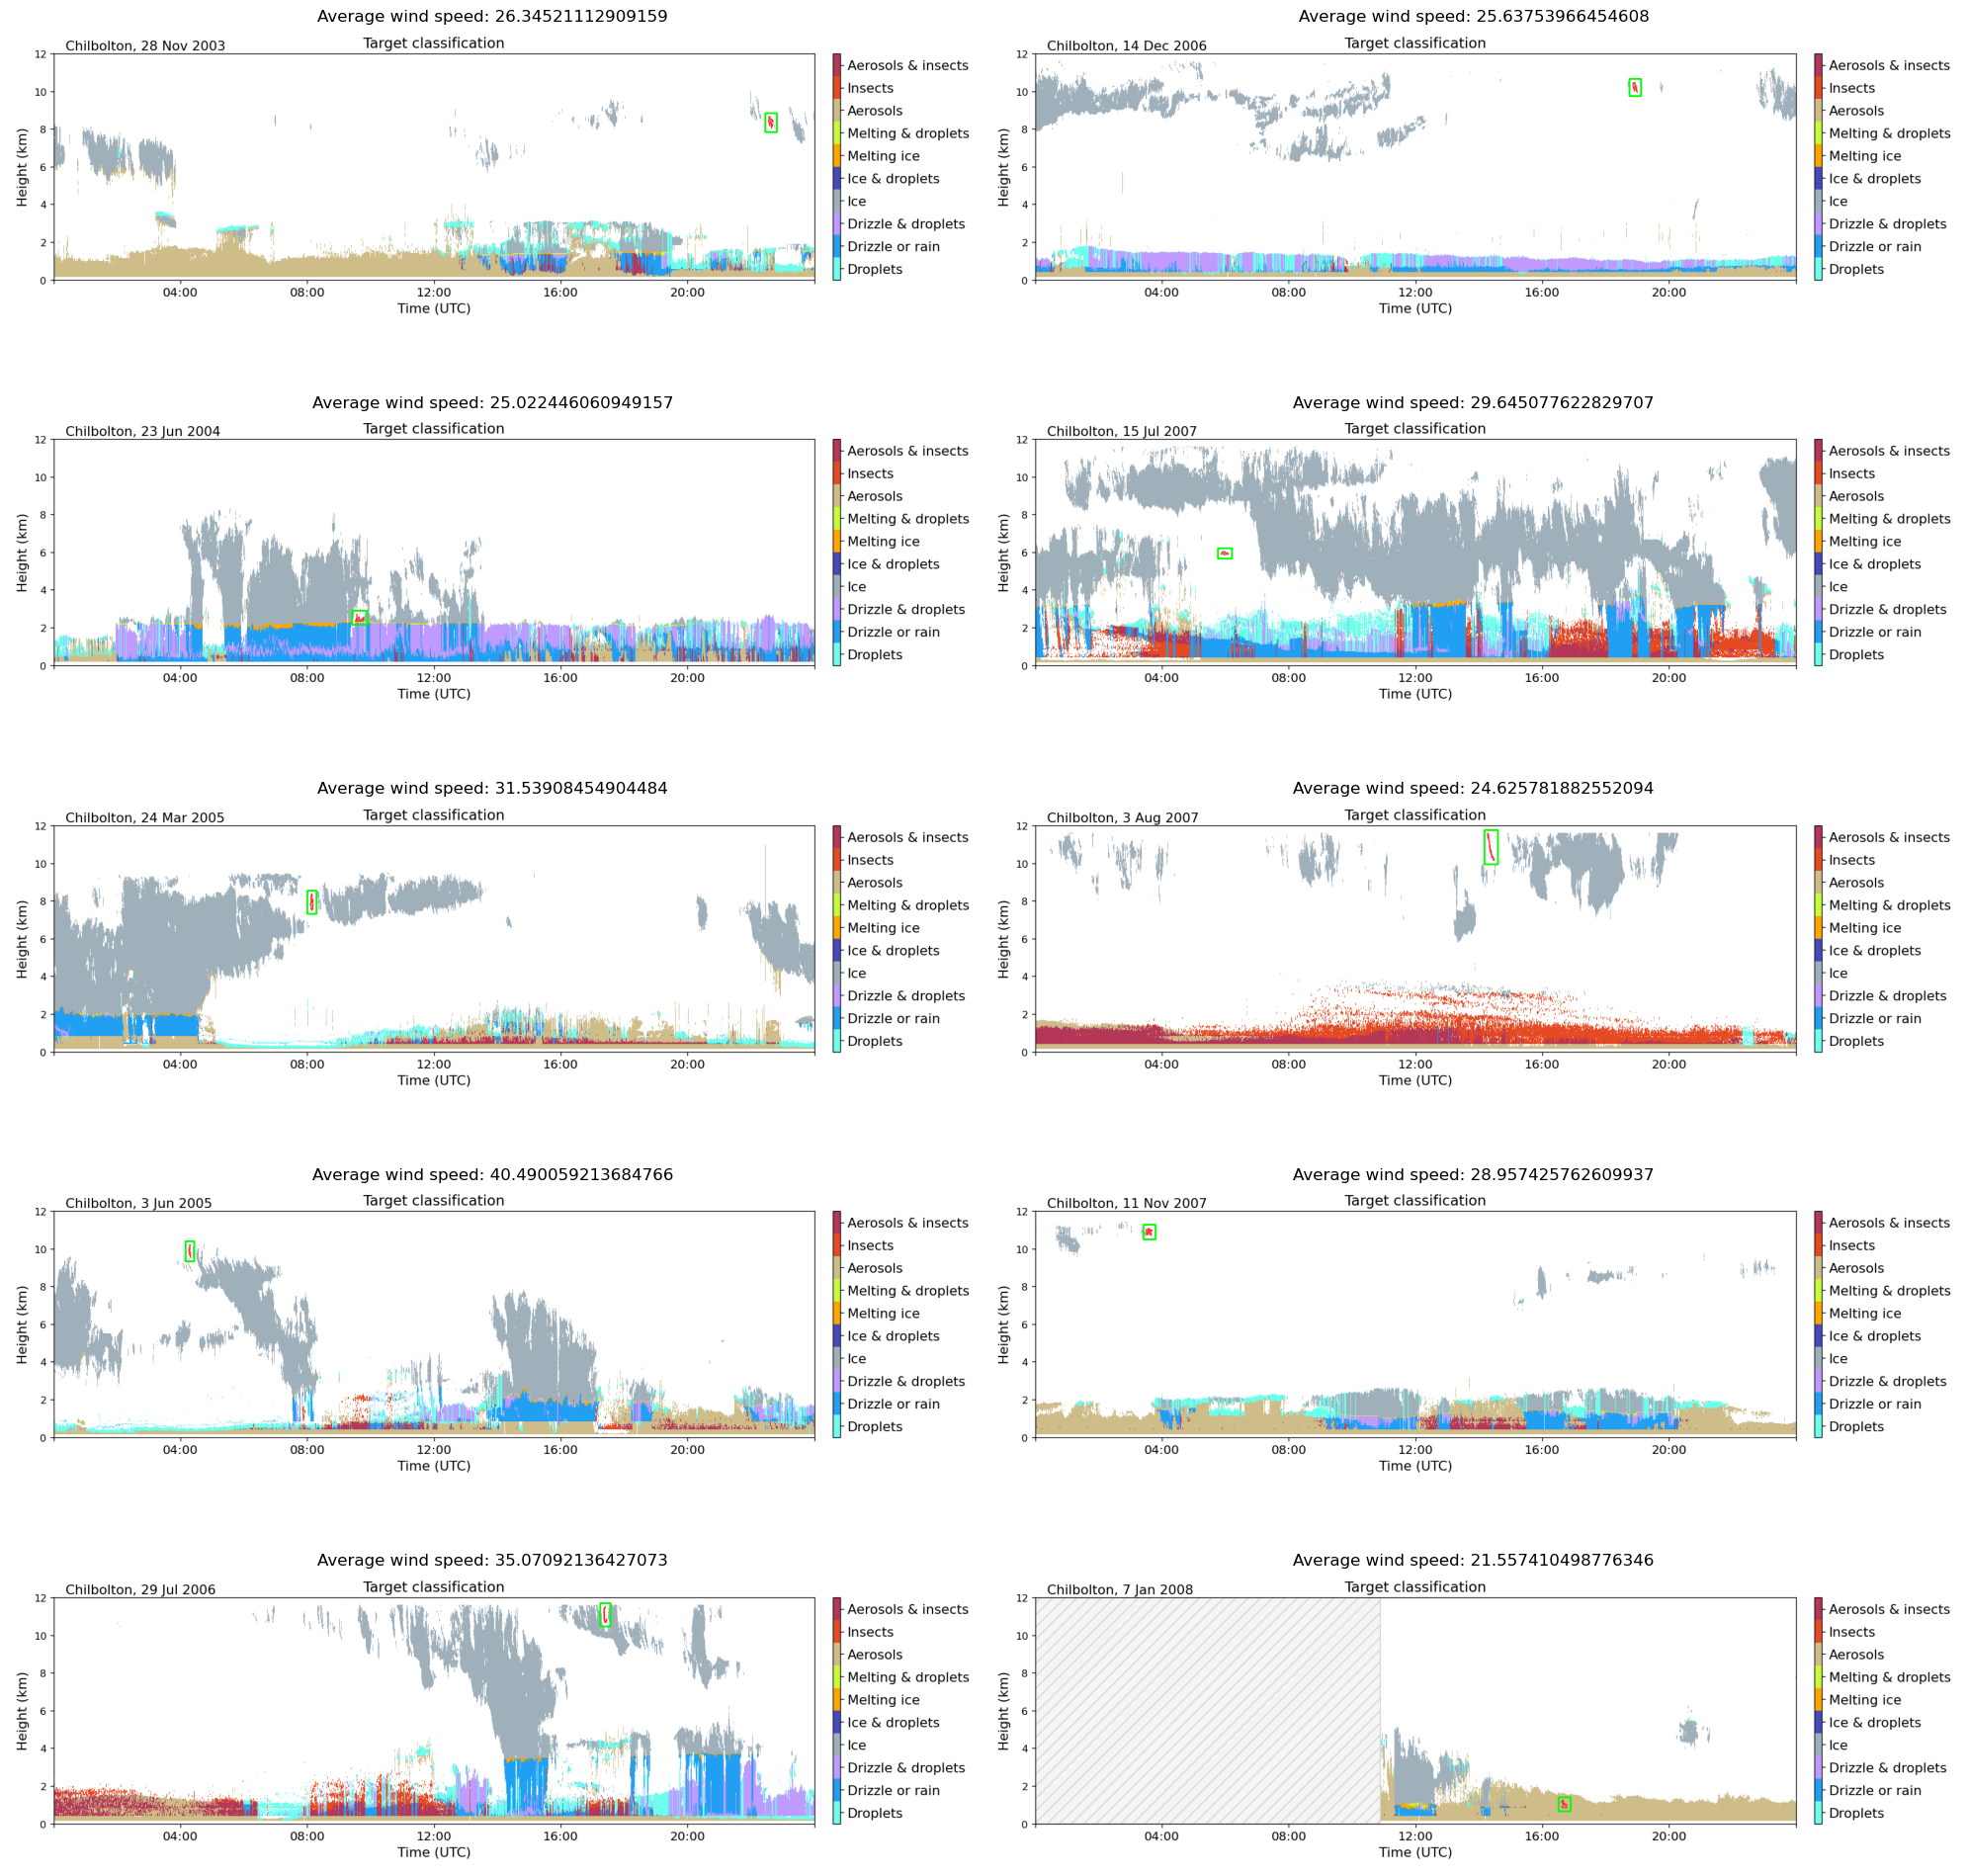

In [5]:
# Change values to decide which area of the histogram to observe cloud shapes
x_min, x_max = 0.3, 0.4
y_min, y_max = 1.31, 1.32

section = [row for _, row in df.iterrows() if x_min < row['area_km'] < x_max and y_min < row['fractal_dimension'] < y_max]
count = 0
fig, ax = plt.subplots(1, figsize=(8, 4))

counts, xedges, yedges, im = ax.hist2d(df['area_km'], df['fractal_dimension'], bins=[bin_area, bin_fractal], norm=mcolors.LogNorm())
ax.add_patch(Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, color='red', linewidth=1.5, fill=False))
ax.set_title('Fractal Dimension against Cloud Area')
ax.set_xlabel('Cloud Area')
ax.set_ylabel('Fractal Dimension')
fig.colorbar(im, ax=ax)

# Change values here to display different number of clouds
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
skip = 0
print(f'Average wind speeds of clouds in the box: {df['wind_speed'].mean()}')
print(f'Number of clouds in the box: {len(df['wind_speed'])}')

for cloud in section:
    # Change number to skip to see different clouds
    if skip < 0:
        skip += 1
        continue

    found = False
    img, contours = find_clouds(f'cloudnet-collection/{cloud['file_name']}')
    for contour in contours:
        if cv2.contourArea(contour) == cloud['area_px'] and cv2.arcLength(contour, True) == cloud['perimeter_px']:
            cv2.drawContours(image=img, contours=[contour], contourIdx=-1, color=(0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img, (x - 5, y - 5), (x + w + 5, y + h + 5), (0, 255, 0), 2)
            found = True
    if found:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Change value here to see different number of clouds
        ax[count % 5,count // 5].imshow(img)
        ax[count % 5, count // 5].set_title(f'Average wind speed: {cloud["wind_speed"]}')
        ax[count % 5,count // 5].set_axis_off()
        count += 1

    # Change value here to see different number of clouds
    if count >= 10:
        break

plt.tight_layout()
plt.show()